In [1]:
!python3 -m pip install pandas
!python3 -m pip install 'pycaret[full]'
!python3 -m pip install 'pycaret[tuners]'
!python3 -m pip install xgboost
!python3 -m pip install scikit-optimize
!python3 -m pip install joblib
!python3 -m pip install 'ray[tune]'
!python3 -m pip install 'tune[search]'


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from pycaret.classification import *
import pandas as pd
import numpy as np

<h2>1. 데이터 로드 및 전처리</h2>

In [5]:
# 1. 데이터 로드

initial_data = pd.read_csv('MCHAT.csv')
cols = pd.read_csv('5most_important_features.csv')

# feature_importance 상위 5개 + subject_id, target label
data = initial_data[cols['Feature']]
data['Class/ASD'] = initial_data['Class/ASD']
data['Subject_Id'] = initial_data['Subject_Id']


# https://github.com/skwgbobf/ASD_Kaggle/blob/main/4.Kaggle1_%20BERT%20Classification.ipynb



# train test 8:2로 나눕니다.
np.random.seed(112)
train, test = np.split(data.sample(frac=1, random_state=42), 
                                     [int(.8*len(data))])

print(len(train), len(test))

114 29


In [6]:
data

,Q23,Q11,Age,language_label,Q2,Class/ASD,Subject_Id
0,0,0,19.0,0.0,0,0,1023032001
1,0,1,19.0,0.0,0,0,1023041312
2,0,0,21.0,0.0,0,0,1523091554
3,0,1,30.0,0.0,0,0,1523101651
4,1,0,30.0,0.0,0,0,1523102651
...,...,...,...,...,...,...,...
138,1,0,22.0,1.0,1,1,1024030441
139,1,0,30.0,1.0,1,1,1124030811
140,0,0,30.0,0.0,0,1,1324031211
141,0,1,20.0,0.0,0,1,1124032011


<h2>2. 전처리</h2>

- categorical data 숫자형으로 변환 + 학습에 관련 없는 칼럼 분리
- https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook

In [7]:
# 2. Preprocess

# Categorical Data 숫자형으로 변환

# https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook
from sklearn import preprocessing

# 데이터 칼럼 추출
cat_cols = list(train.select_dtypes('object').columns.values)

# 전처리 과정을 위해서 train과 test 셋들을 잠시 합칩니다.
df = pd.concat([train, test], axis=0)

# 데이터 타입을 모두 숫자형으로 통일
label_encoder = preprocessing.LabelEncoder()
for col in cat_cols:
    df[col]= label_encoder.fit_transform(df[col])

# train test를 다시 8:2로 나눕니다
train = df.iloc[:train.shape[0], :]
test = df.iloc[train.shape[0]:, :]

In [8]:
import enum
import random
import os

# https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook

# 사용할 시드값 변환 함수
def random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# 시드값, CV fold 개수, 훈련 조기중단 변수 설정
class Config(enum.Enum):
    SEED = 42
    N_FOLDS = 5
    EARLY_STOP = 300

random_seed(Config.SEED.value)

<h2>3. XGBoost Hypter Parameter 설명 </h2> 


XGBoost + SHAP (하이퍼 파라미터 사용) <br>
https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook

DMatrix() 사용 불가능 - DMatrix는 모델 학습 속도 상승 효과만 있음 <br>
pycaret에서 early stopping method 사용 불가능 / xgboost에서만 가능 - 모델 학습 속도 사응 효과만 있음 <br>
https://xgboost.readthedocs.io/en/stable/python/python_api.html



In [9]:
# https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook

# xgboost 하이퍼파라미터 세팅
xgb_params=  {'n_estimators':10000,
              'learning_rate': 0.002,
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'max_depth': 10,
              'alpha': 0.5108154566815425,
              'gamma': 1.9276236172849432,
              'reg_lambda': 11.40999855634382,
              'colsample_bytree': 0.705851334291963,
              'subsample': 0.8386116751473301,
              'min_child_weight': 2.5517043283716605,
              #'early_stopping_rounds': Config.EARLY_STOP.value, # 학습 도중 모델이 발전이 없을 때 학습을 멈출 수 있게 하는 파라미터들
              #'evals' = [(dtrain, 'train'), (deval, 'eval')],   # pycaret에서 사용 불가능 / xgboost에서만 가능
              #'verbose_eval': 1000, 

}

<h2> 4. Model definition and Training</h2>

Pycaret Classification <br>
https://www.kaggle.com/code/venkatkumar001/apc-3-pycaret-identify-best-algo-s/notebook

학습 모델: XGBoost <br>
evaludation 방식: Stratified K-fold Cross Validation 

In [10]:
# 3. Training

# https://www.kaggle.com/code/venkatkumar001/apc-3-pycaret-identify-best-algo-s/notebook

import xgboost as xgb

# 모델 생성에 사용될 설정
reg = setup(data=train, # 
           target= 'Class/ASD', # columns = [col for col in train.columns if col not in ['ID', 'age_desc', 'Class/ASD'] ] 
           session_id = Config.SEED.value, # random_state = Config.SEED.value
           verbose = False, # silent = True
           fold = Config.N_FOLDS.value, # n_splits = Config.F_FOLDS.value
           data_split_shuffle = True, # shuffle = True
           ignore_features = ['Subject_Id'] # columns = [col for col in train.columns if col not in ['ID', 'age_desc', 'Class/ASD'] ] 
           )

# 모델 생성: XGBoost + Stratified K-fold Cross-Validation 사용
xgboost = create_model(
    'xgboost',
    **xgb_params # xgboost 모델에 hyper parameter 입력
    )



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.8438,1.0000,0.7500,0.8571,0.0000,0.0000
1,0.7500,0.8333,1.0000,0.7500,0.8571,0.0000,0.0000
2,0.7500,0.7500,1.0000,0.7500,0.8571,0.0000,0.0000
3,0.7500,0.6667,1.0000,0.7500,0.8571,0.0000,0.0000
4,0.7333,0.8409,1.0000,0.7333,0.8462,0.0000,0.0000
Mean,0.7467,0.7869,1.0000,0.7467,0.8549,0.0000,0.0000
Std,0.0067,0.0695,0.0000,0.0067,0.0044,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [11]:

# hyper parameter 튜닝 (Random Grid Search 사용)
tuned_xgboost = tune_model(
    xgboost,
    search_library = 'scikit-optimize',
    search_algorithm = 'bayesian'
    )

# 모델 예측
predict_value = tuned_xgboost.predict(test.drop(['Subject_Id', 'Class/ASD'], axis = 1)) # shap_preds = tuned_xgboost.predict(test)
predict_model(tuned_xgboost, data = test.drop(['Subject_Id', 'Class/ASD'], axis = 1))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.8125,1.0000,0.7500,0.8571,0.0000,0.0000
1,0.7500,0.8333,1.0000,0.7500,0.8571,0.0000,0.0000
2,0.7500,0.9375,1.0000,0.7500,0.8571,0.0000,0.0000
3,0.7500,0.8333,1.0000,0.7500,0.8571,0.0000,0.0000
4,0.7333,0.4773,1.0000,0.7333,0.8462,0.0000,0.0000
Mean,0.7467,0.7788,1.0000,0.7467,0.8549,0.0000,0.0000
Std,0.0067,0.1570,0.0000,0.0067,0.0044,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Q23,Q11,Age,language_label,Q2,prediction_label,prediction_score
88,0,0,18.0,0.0,0,1,0.6974
126,1,0,30.0,1.0,1,1,0.8468
21,0,1,24.0,0.0,0,1,0.6873
57,0,0,28.0,1.0,0,1,0.7480
75,0,1,28.0,0.0,0,1,0.6873
32,0,0,18.0,0.0,0,1,0.6974
137,1,0,29.0,1.0,1,1,0.8468
59,0,0,27.0,0.0,0,1,0.6873
63,1,0,24.0,1.0,1,1,0.8468
128,1,0,28.0,1.0,0,1,0.8466


<h2>5. Visualization</h2>

In [12]:
evaluate_model(tuned_xgboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

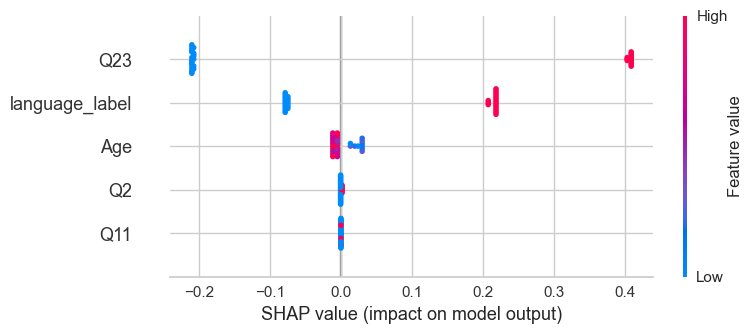

In [14]:
# SHAP 결과
interpret_model(tuned_xgboost, plot = 'summary')
interpret_model(tuned_xgboost, plot = 'msa')

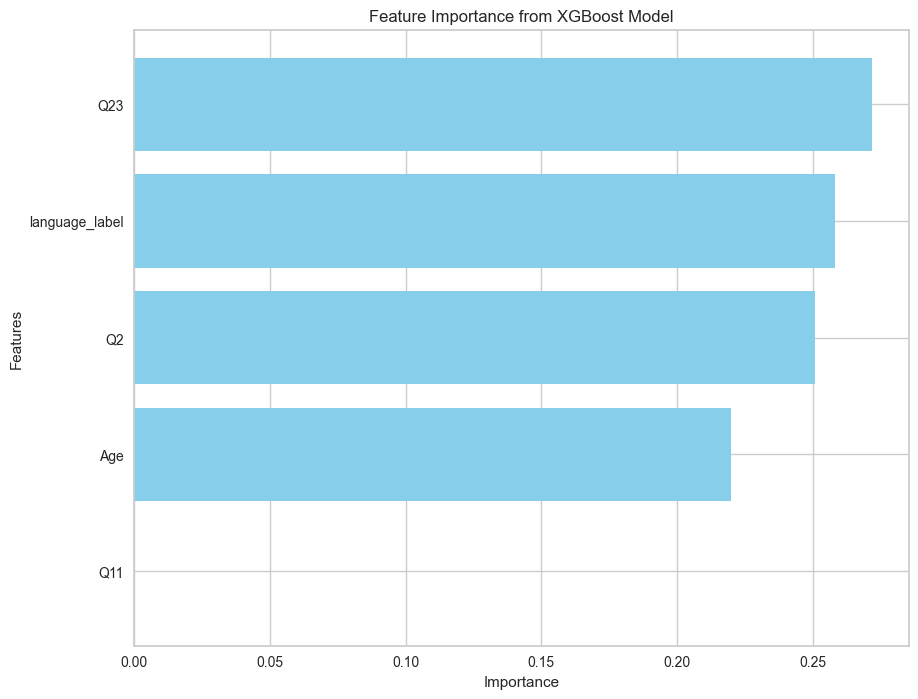

In [15]:
#feature importance

import matplotlib.pyplot as plt

feature_imp = pd.DataFrame({
    'Feature': test.drop(['Subject_Id', 'Class/ASD'], axis = 1).columns,
    'Importance': tuned_xgboost.feature_importances_
}).sort_values(by='Importance', ascending=False)
#print(feature_imp)

# Plotting the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance from XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important at the top
plt.show()

<h2>6. Prediction</h2>

In [16]:
predict_model(tuned_xgboost, data = test);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7931,0.8116,1.0000,0.7931,0.8846,0.0000,0.0000
